In [38]:
import tensorflow as tf
import pickle
import os
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import ReLU, Resizing, Rescaling, concatenate
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.summary import scalar, create_file_writer
import time
import datetime
import keras
from tensorflow.io import read_file, decode_jpeg
from tensorflow import cast, shape
from tensorflow.image import resize_with_pad, ResizeMethod
from IPython import display
import matplotlib.pyplot as plt

# Generator and Discriminator

In [2]:
def downsample(filters, size, strides, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Make sequential model
    result = Sequential()
    # Add Conv2D
    result.add(Conv2D(filters, size, strides = strides, padding = 'same',
                             kernel_initializer = initializer, use_bias = False))

    # Optionally add batchnorm
    if apply_batchnorm:
        result.add(BatchNormalization())

    # Add leaky relu
    result.add(LeakyReLU(alpha = 0.2))

    return result

In [3]:
def upsample(filters, size, strides, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)

    # Make sequential model
    result = Sequential()
    # Add deconv layer (conv2dtranspose)
    result.add(Conv2DTranspose(filters, size, strides = strides,
                                    padding='same',
                                    kernel_initializer = initializer,
                                    use_bias = False))

    # Add batchnorm
    result.add(BatchNormalization())

    # Optionally add dropout
    if apply_dropout:
        result.add(Dropout(0.5))
    
    # Add relu
    result.add(ReLU())

    return result

In [4]:
def create_generator():
    inputs = Input(shape = [256, 256, 1])
    
    # Define downsampling layers
    down_stack = [
        downsample(64, 4, 2, apply_batchnorm = False),
        downsample(128, 4, 2),
        downsample(256, 4, 2),
        downsample(512, 4, 2),
        downsample(512, 4, 2),
        downsample(512, 4, 2),
        downsample(512, 4, 2),
        downsample(512, 4, 2)
    ]
    
    # Define upsampling layers
    up_stack = [
        upsample(512, 4, 2, apply_dropout = True),
        upsample(512, 4, 2, apply_dropout = True),
        upsample(512, 4, 2, apply_dropout = True),
        upsample(512, 4, 2),
        upsample(256, 4, 2),
        upsample(128, 4, 2),
        upsample(64, 4, 2),
    ]
    
    # Last layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides = 2, padding = 'same',
                                           kernel_initializer = initializer, activation = 'tanh')
    
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs = inputs, outputs = x)

In [5]:
def create_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape = [256, 256, 1], name = 'sketch')
    tar = tf.keras.layers.Input(shape = [256, 256, 1], name = 'target')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4, 2, False)(x)
    down2 = downsample(128, 4, 2)(down1)
    down3 = downsample(256, 4, 2)(down2)
    down4 = downsample(512, 4, 1)(down3)

    last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(down4)

    return tf.keras.Model(inputs = [inp, tar], outputs = last)

# Classes and Losses

In [ ]:
# def sum_tv_loss(image):
#     loss_y = tf.nn.l2_loss(image[:, 1:, :, :] - image[:, :-1, :, :])
#     loss_x = tf.nn.l2_loss(image[:, :, 1:, :] - image[:, :, :-1, :])
#     loss = 2 * (loss_y + loss_x)
#     loss = tf.cast(loss, tf.float32)
#     return loss


In [ ]:
# def feature_loss(image, vgg):
#     vgg.build(image)
#     output = vgg.get_layer('block3_conv3').output
# #     input_tensor = tf.keras.Input(shape = (56, 56, 256))
# #     new_model = tf.keras.Model(inputs = input_tensor, outputs = conv_layer(input_tensor))
# #     output = new_model(image)
    
#     return output

In [ ]:
# @tf.function
# def discriminator_loss(predict_real, predict_fake):
#     return tf.reduce_mean(-(tf.log(predict_real + 1e-12) + tf.log(1 - predict_fake + 1e-12)))


In [ ]:
# @tf.function
# def generator_loss(targets, outputs, predict_fake, net1, net2):
#     gen_loss_GAN = -tf.reduce_mean(predict_fake)
#     gen_loss_L1 = tf.reduce_mean(tf.abs(targets - outputs))
#     gen_loss_tv = tf.reduce_mean(tf.sqrt(tf.nn.l2_loss(sum_tv_loss(outputs))))
# #     gen_loss_f = tf.reduce_mean(tf.sqrt(tf.nn.l2_loss(feature_loss(targets,net1) - feature_loss(outputs,net2))))
#     gen_total_loss = gen_loss_GAN + (gen_loss_L1 * 10) + (gen_loss_tv * 1e-5)
# #     + (gen_loss_f * 1e-4)
    
#     return gen_total_loss, gen_loss_GAN, gen_loss_L1, gen_loss_tv
# # , gen_loss_f

In [9]:
#     def train_step(self, sketches, images):
                
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             generated_images = self.generator(sketches, training = True)

#             predict_real = self.discriminator([sketches, images], training = True)
#             predict_fake = self.discriminator([sketches, generated_images], training = True)

#             gen_step_loss = self.g_loss(images, generated_images, predict_fake, self.net1, self.net2)
#             disc_step_loss = self.d_loss(predict_real, predict_fake)

#         gen_grad = gen_tape.gradient(gen_step_loss, self.generator.trainable_variables)
#         disc_grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
#         # Monitor loss.
#         self.gen_loss_tracker.update_state(gen_step_loss)
#         self.disc_loss_tracker.update_state(disc_step_loss)

#         return {"g_loss": self.gen_loss_tracker.result(), "d_loss": self.disc_loss_tracker.result()}

In [ ]:

# class discrim_loss(tf.keras.losses.Loss):
#     def __init__(self):
#         super().__init__()
        
#     def call(self, y_true, y_pred):
#         return descriminator_loss(y_true, y_pred)

In [ ]:
# class gen_loss(tf.keras.losses.Loss):
#     def __init__(self, predict_fake = None, net1 = None, net2 = None):
#         super().__init__()
#         self.predict_fake = predict_fake
#         self.net1 = net1
#         self.net2 = net2
# 
#     def call(self, y_true, y_pred):
#         return generator_loss(y_true, y_pred, self.predict_fake, self.net1, self.net2)

In [ ]:
# class autopainter(tf.keras.Model):
    
#     def __init__(self, discriminator, generator, net1, net2):
#         super(autopainter, self).__init__()
#         self.discriminator = discriminator
#         self.generator = generator
#         self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
#         self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
#         self.net1 = net1
#         self.net2 = net2
    
#     @property
#     def metrics(self):
#         return [self.gen_loss_tracker, self.disc_loss_tracker]
    
#     def compile(self, d_optimizer, g_optimizer):
#         super(autopainter, self).compile()
#         self.d_optimizer = d_optimizer
#         self.g_optimizer = g_optimizer
#         self.d_loss = discrim_loss()
#         self.g_loss = gen_loss(predict_fake = None, net1 = self.net1, net2 = self.net2)
#         self.summary_writer = create_file_writer('../logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        
#     @tf.function    
#     def train_step(self, pair):
#         sketch = pair[0]
#         target = pair[1]
        
# #         gen_loss = 0
# #         disc_loss = 0
        
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             gen_output = self.generator(sketch, training = True)

#             disc_real_output = self.discriminator([sketch, target], training = True)
#             disc_generated_output = self.discriminator([sketch, gen_output], training = True)
            
#             self.g_loss.predict_fake = disc_generated_output

# #             gen_total_loss, gen_loss_GAN, gen_loss_L1, gen_loss_tv =\
# #                                 self.g_loss(target, gen_output)
#             #             , gen_loss_f =\
#             disc_loss = self.d_loss(disc_real_output, disc_generated_output)

# #         generator_gradients = gen_tape.gradient(gen_total_loss,
# #                                               self.generator.trainable_variables)
#         discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                    self.discriminator.trainable_variables)

# #         self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
#         self.d_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

# #         with self.summary_writer.as_default():
# #             scalar('gen_total_loss', gen_total_loss)
# #                    , step = step // 1000)
# #             scalar('gen_gan_loss', gen_loss_GAN)
# #                    , step = step // 1000)
# #             scalar('gen_l1_loss', gen_loss_L1)
# #                    , step = step // 1000)
# #             scalar('gen_tv_loss', gen_loss_tv)
# #                    , step = step // 1000)
# #             scalar('gen_f_loss', gen_loss_f)
# #                    , step = step // 1000)
# #             scalar('disc_loss', disc_loss)
# #                    , step = step // 1000)

# Preprocessing

In [39]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
    pair = read_file(image_file)
    pair = decode_jpeg(pair)
    
    w = shape(pair)[1]
    w = w // 2
    
    image = pair[:, w:, :]
    sketch = pair[:, :w, :]

  # Convert both images to float32 tensors
    sketch = cast(sketch, tf.float32)
    image = cast(image, tf.float32)

    return sketch, image

In [40]:
def resize(sketch, image, height, width):
    sketch_resized = resize_with_pad(sketch, height, width, method = ResizeMethod.NEAREST_NEIGHBOR)
    image_resized = resize_with_pad(image, height, width, method = ResizeMethod.NEAREST_NEIGHBOR)

    return sketch_resized, image_resized

In [41]:
# Normalizing the images to [0, 1]
def normalize(sketch, image):
    sketch_scaled = sketch / 255
    image_scaled = image / 255

    return sketch_scaled, image_scaled

In [42]:
def load_image_and_sketch(image_file):
    sketch, image = load(image_file)
    sketch, image = resize(sketch, image, 256, 256)
    sketch, image = normalize(sketch, image)

    return sketch, image

In [112]:
train_dataset = tf.data.Dataset.list_files('../data/train/*.jpg')
train_dataset = train_dataset.map(load_image_and_sketch,
                                  num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1524)
train_dataset = train_dataset.batch(16)

In [113]:
validation_dataset = tf.data.Dataset.list_files('../data/validation/*.jpg')
validation_dataset = validation_dataset.map(load_image_and_sketch,
                                  num_parallel_calls = tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(16)

In [114]:
test_dataset = tf.data.Dataset.list_files('../data/test/*.jpg')
test_dataset = test_dataset.map(load_image_and_sketch,
                                  num_parallel_calls = tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(16)

In [115]:
generator = create_generator()
discriminator = create_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
# net1 = VGG16()
# net2 = VGG16()

In [98]:
# net1.get_layer('block3_conv3')

In [99]:
# net1.summary()

In [100]:
# net1.block3_conv3

In [101]:
# model = autopainter(discriminator, generator, net1, net2)

In [102]:
# d_loss = discrim_loss()
# g_loss = gen_loss()

In [103]:
# model.compile(discriminator_optimizer, generator_optimizer)

In [104]:
# model.fit(train_dataset, epochs = 10, validation_data = validation_dataset)

Time taken for 200 steps: 2520.05 sec



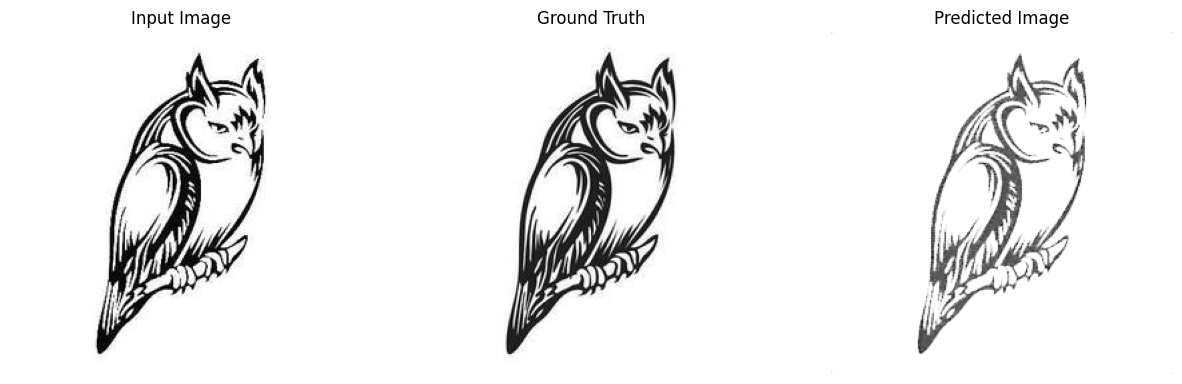

Step: 2400
......

KeyboardInterrupt: 

In [119]:
fit_pix2pix(train_dataset, test_dataset, steps=5000)

# Training

In [85]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [86]:
pix2pix_log_dir="../logs/pix2pix/"

summary_writer = tf.summary.create_file_writer(
    pix2pix_log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [87]:
def generator_loss_pix2pix(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [88]:
def discriminator_loss_pix2pix(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [117]:
def train_step_pix2pix(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss_pix2pix(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss_pix2pix(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
        tf.summary.scalar('disc_loss', disc_loss, step=step)

In [68]:
# def train_step(self, pair):
#         sketch = pair[0]
#         target = pair[1]
        
# #         gen_loss = 0
# #         disc_loss = 0
        
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             gen_output = self.generator(sketch, training = True)

#             disc_real_output = self.discriminator([sketch, target], training = True)
#             disc_generated_output = self.discriminator([sketch, gen_output], training = True)
            
#             self.g_loss.predict_fake = disc_generated_output

# #             gen_total_loss, gen_loss_GAN, gen_loss_L1, gen_loss_tv =\
# #                                 self.g_loss(target, gen_output)
#             #             , gen_loss_f =\
#             disc_loss = self.d_loss(disc_real_output, disc_generated_output)

# #         generator_gradients = gen_tape.gradient(gen_total_loss,
# #                                               self.generator.trainable_variables)
#         discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                    self.discriminator.trainable_variables)

# #         self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
#         self.d_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

# #         with self.summary_writer.as_default():
# #             scalar('gen_total_loss', gen_total_loss)
# #                    , step = step // 1000)
# #             scalar('gen_gan_loss', gen_loss_GAN)
# #                    , step = step // 1000)
# #             scalar('gen_l1_loss', gen_loss_L1)
# #                    , step = step // 1000)
# #             scalar('gen_tv_loss', gen_loss_tv)
# #                    , step = step // 1000)
# #             scalar('gen_f_loss', gen_loss_f)
# #                    , step = step // 1000)
# #             scalar('disc_loss', disc_loss)
# #                    , step = step // 1000)

# Checkpointing and Saving

In [90]:
checkpoint_dir = '../checkpoints/pix2pix/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [91]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.imshow(display_list[i], cmap = 'gray')
        plt.axis('off')
    plt.show()

In [92]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('../logs/pix2pix/images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [118]:
def fit_pix2pix(train_ds, test_ds, steps):
    example_target, example_input = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 200 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 200 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step}")

        train_step_pix2pix(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 1000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)